In [9]:
# 라이브러리 추가하기
from selenium import webdriver 
from bs4 import BeautifulSoup 
import time
import pandas as pd
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform

In [19]:
class Ranking():

    def __init__(self):
        self.results = []
        self.df = pd.DataFrame

    # 광고 닫기
    def close_ad(self):
        iframes = self.driver.find_elements(By.TAG_NAME, "iframe")
        for iframe in iframes:
            try:
                self.driver.switch_to.frame(iframe)
                try:
                    close_btn = self.driver.find_element(By.CSS_SELECTOR, 'div[aria-label="광고 닫기"]')
                    close_btn.click()
                    self.driver.switch_to.default_content()
                    break
                except:
                    pass
                iframes_inside = self.driver.find_elements(By.TAG_NAME, "iframe")
                if iframes_inside:
                    self.close_ad()
                self.driver.switch_to.default_content()
            except:
                break
    # 랭킹 데이터 가져오기
    def get_ranking(self):
            html = self.driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            channel_list = soup.select('form > table > tbody > tr')
            for channel in channel_list:
                title = channel.select('h1 > a')[0].text.strip() 
                category = channel.select('p.category')[0].text.strip()
                subscriber = channel.select('.subscriber_cnt')[0].text 
                view = channel.select('.view_cnt')[0].text
                video = channel.select('.video_cnt')[0].text
                data = [title, category, subscriber, view, video]
                self.results.append(data)
    # 페이지별 URL로 크롤링하는 방식
    def by_page(self, page):
        self.driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
        self.results = []
        for page in range(1, page):
            url = f"https://youtube-rank.com/board/bbs/board.php?bo_table=youtube&page={page}" 
            self.driver.get(url)
            time.sleep(2)
            self.get_ranking()
        self.driver.quit()
        self.save_to_excel()
        self.draw_graph()
    # 다음 버튼 클릭으로 크롤링하는 방식
    def by_click(self, page):
        self.driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
        self.results = []
        url = "https://youtube-rank.com/board/bbs/board.php?bo_table=youtube" 
        self.driver.get(url)
        time.sleep(2)

        for i in range(page):
            print(f"현재 진행 상태 : {i+1} 페이지 작업중")
            self.get_ranking()
            
            # 다음 페이지 버튼 클릭
            pg_current = self.driver.find_element(By.CSS_SELECTOR,'.pg_current').text
            nxt_btn = self.driver.find_elements(By.CSS_SELECTOR,'.pg_page')
            for btn in nxt_btn:
                # 현재 페이지가 10의 배수(10,20,30..)일 경우에는 다음 페이지 버튼을 클릭해야함
                if btn.text.isdigit() and int(pg_current) % 10 == 0:
                    nxt_page_btn = self.driver.find_element(By.CSS_SELECTOR,'.pg_next')
                    nxt_page_btn.click()
                    time.sleep(1)
                    try:
                        self.close_ad()
                        break
                    except:
                        break
                # 그 외에는 (현재 페이지 + 1) 버튼을 클릭
                elif btn.text.isdigit():
                    if int(pg_current) +1 == int(btn.text):
                        btn.click()
                        time.sleep(1)
                        try:
                            self.close_ad()
                            break
                        except:
                            break
        self.driver.quit()
        self.save_to_excel()
        self.draw_graph()

    # 데이터프레임 엑셀 파일로 저장하기
    def save_to_excel(self):
        # 데이터 칼럼명을 설정하고 엑셀 파일로 저장하기
        self.df = pd.DataFrame(self.results)
        self.df.columns = ['title', 'category', 'subscriber', 'view', 'video']
        # 엑셀에서 허용하지 않는 특수문자를 가지고 있어 에러 발생
        # 해당 특수문자를 replace로 삭제
        self.df["title"] = self.df["title"].str.replace("","")
        self.df.to_excel('youtube_rank.xlsx', index = False)

        # 반복문으로 유튜브 랭킹 화면의 여러 페이지를 크롤링하기
        # 버튼 클릭으로 다음페이지 넘어가는 방식
    
    # 시각화
    def draw_graph(self):
        if platform.system() == 'Windows':
            path = 'c:/Windows/Fonts/malgun.ttf'
            font_name = font_manager.FontProperties(fname = path).get_name()
            rc('font', family = font_name)
        elif platform.system() == 'Darwin':
            rc('font', family = 'AppleGothic')
        else:
            print('Check your OS system')
        
        df = pd.read_excel('youtube_rank.xlsx')
        # replaced_subscriber 시리즈 문자열 변경하기
        df['replaced_subscriber'] = df['subscriber'].str.replace('만', '0000')
        # Series 데이터 타입 변환하기
        df['replaced_subscriber'] = df['replaced_subscriber'].astype('int')
        # 카테고리별 구독자 수, 채널 수 피봇 테이블 생성하기
        pivot_df = df.pivot_table(index = 'category', values = 'replaced_subscriber', aggfunc = ['sum','count'])
        # 데이터프레임의 칼럼명 변경하기
        pivot_df.columns = ['subscriber_sum', 'category_count']
        # 데이터프레임의 인덱스 초기화하기
        pivot_df = pivot_df.reset_index()
        # 데이터프레임을 내림차순 정렬하기
        pivot_df = pivot_df.sort_values(by='subscriber_sum', ascending=False)
        # 카테고리별 구독자 수 시각화하기
        plt.figure(figsize = (30,10))
        plt.title("카테고리별 구독자 수")
        plt.pie(pivot_df['subscriber_sum'], labels=pivot_df['category'], autopct='%1.1f%%')
        plt.show()
        # 카테고리별 채널 수 시각화하기
        pivot_df = pivot_df.sort_values(by='category_count', ascending=False)
        plt.figure(figsize = (30,10))
        plt.title("카테고리별 채널 수")
        plt.pie(pivot_df['category_count'], labels=pivot_df['category'], autopct='%1.1f%%')
        plt.show()

In [21]:
tmp = Ranking()

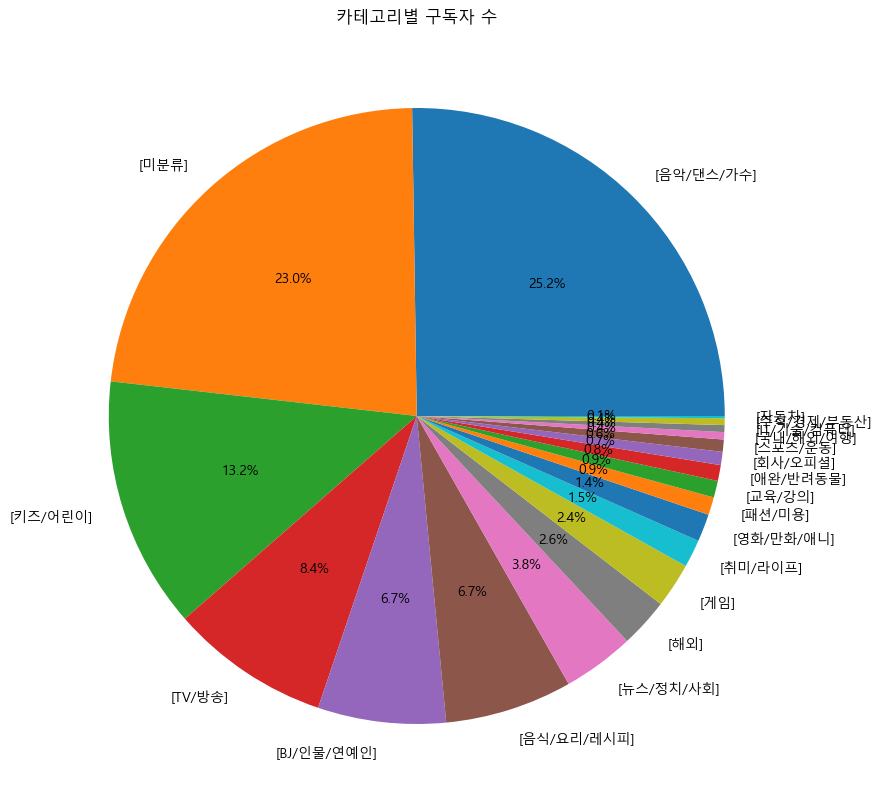

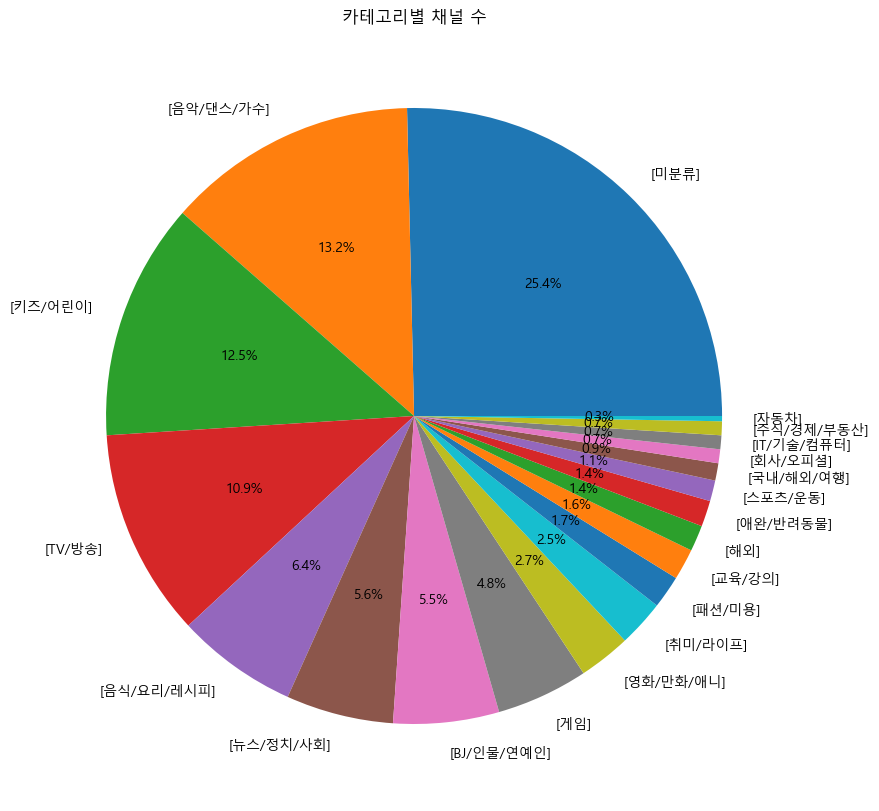

In [23]:
tmp.by_page(12)

현재 진행 상태 : 1 페이지 작업중
현재 진행 상태 : 2 페이지 작업중
현재 진행 상태 : 3 페이지 작업중
현재 진행 상태 : 4 페이지 작업중
현재 진행 상태 : 5 페이지 작업중
현재 진행 상태 : 6 페이지 작업중
현재 진행 상태 : 7 페이지 작업중
현재 진행 상태 : 8 페이지 작업중
현재 진행 상태 : 9 페이지 작업중
현재 진행 상태 : 10 페이지 작업중
현재 진행 상태 : 11 페이지 작업중


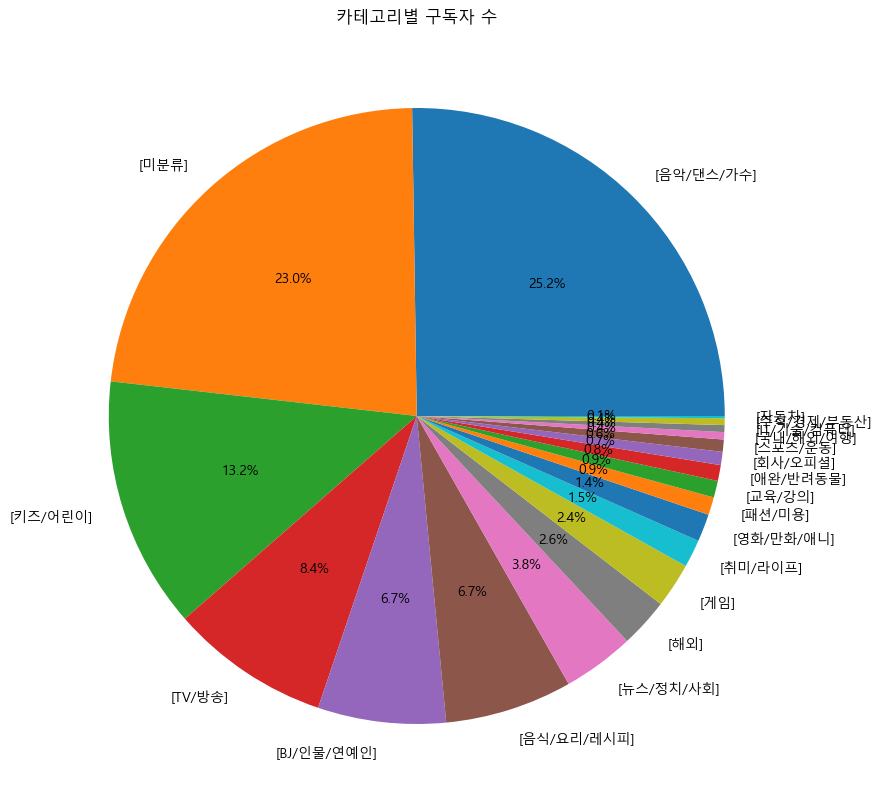

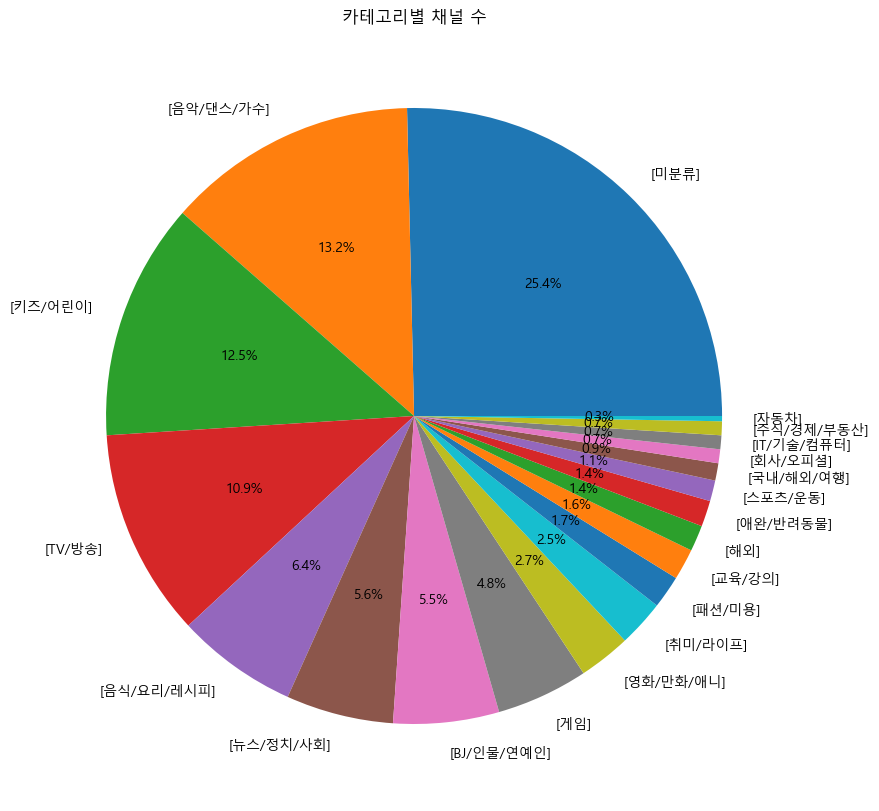

In [24]:
tmp.by_click(11)